In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.layers import (Input, Conv2D, BatchNormalization, ZeroPadding2D,
                          MaxPooling2D, Activation, Dense, Dropout, Flatten)
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.datasets import mnist
import os
import sys

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns

In [3]:
def vgg16_digits(MODEL_NAME):
    x = Input(shape = (16, 15, 1))
    y = ZeroPadding2D(padding = (8, 9))(x) 

    y = multiConvLayer(y, 64, 2) # size 32x32
    y = multiConvLayer(y, 128, 2) # size 16x16
    y = multiConvLayer(y, 256, 3) # size 8x8
    y = multiConvLayer(y, 512, 3) # size 4x4
    y = multiConvLayer(y, 512, 3) # size 2x2
    y = Flatten()(y)
    y = Dense(units = 4096, activation='relu')(y)
    y = Dense(units = 4096, activation='relu')(y)
    y = Dense(units = 10)(y)
    y = Activation('softmax')(y)

    return Model(x, y, name = MODEL_NAME)

In [4]:
def vgg19_digits(MODEL_NAME):
    x = Input(shape = (16, 15, 1))
    y = ZeroPadding2D(padding = (8, 9))(x) 

    y = multiConvLayer(y, 64, 2) # size 32x32
    y = multiConvLayer(y, 128, 2) # size 16x16
    y = multiConvLayer(y, 256, 4) # size 8x8
    y = multiConvLayer(y, 512, 4) # size 4x4
    y = multiConvLayer(y, 512, 4) # size 2x2
    y = Flatten()(y)
    y = Dense(units = 4096, activation='relu')(y)
    y = Dense(units = 4096, activation='relu')(y)
    y = Dense(units = 10)(y)
    y = Activation('softmax')(y)

    return Model(x, y, name = MODEL_NAME)

In [5]:
def vgg16_mnist(MODEL_NAME):
    x = Input(shape = (28, 28, 1))
    y = ZeroPadding2D(padding = (2, 2))(x) 

    y = multiConvLayer(y, 64, 2) # size 32x32
    y = multiConvLayer(y, 128, 2) # size 16x16
    y = multiConvLayer(y, 256, 3) # size 8x8
    y = multiConvLayer(y, 512, 3) # size 4x4
    y = multiConvLayer(y, 512, 3) # size 2x2
    y = Flatten()(y)
    y = Dense(units = 4096, activation='relu')(y)
    y = Dense(units = 4096, activation='relu')(y)
    y = Dense(units = 10)(y)
    y = Activation('softmax')(y)

    return Model(x, y, name = MODEL_NAME)

In [6]:
def vgg19_mnist(MODEL_NAME):
    x = Input(shape = (28, 28, 1))
    y = ZeroPadding2D(padding = (2, 2))(x) 

    y = multiConvLayer(y, 64, 2) # size 32x32
    y = multiConvLayer(y, 128, 2) # size 16x16
    y = multiConvLayer(y, 256, 4) # size 8x8
    y = multiConvLayer(y, 512, 4) # size 4x4
    y = multiConvLayer(y, 512, 4) # size 2x2
    y = Flatten()(y)
    y = Dense(units = 4096, activation='relu')(y)
    y = Dense(units = 4096, activation='relu')(y)
    y = Dense(units = 10)(y)
    y = Activation('softmax')(y)

    return Model(x, y, name = MODEL_NAME)

In [7]:
def multiConvLayer(x, value, n):
    y = x
    for _ in range(n):
        y = Conv2D(value, (3, 3), padding = 'same')(y)
        y = Activation('relu')(y)
    y = MaxPooling2D(pool_size=(2, 2), strides = (2, 2))(y)
    return y

In [8]:
def checkDir(modelName):
    # Used to create all necessary folders
    # Not implemented yet
    if not os.path.exists('models'):
        os.makedirs('models')
    
    # Used to save the logs
    if not os.path.exists('logs'):
        os.makedirs('logs')
        
    # Used to save the logs
    if not os.path.exists('images'):
        os.makedirs('images')
        
    if not os.path.exists('models/'+modelName):
        os.makedirs('models/'+modelName)
        
    if not os.path.exists('images/'+modelName):
        os.makedirs('images/'+modelName)

In [9]:
def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.reshape(-1, 28, 28, 1)
    x_test = x_test.reshape(-1, 28, 28, 1)
    y_train = to_categorical(y_train) # encode one-hot vector
    y_test = to_categorical(y_test)

    num_of_test_data = 50000
    x_val = x_train[num_of_test_data:]
    y_val = y_train[num_of_test_data:]
    x_train = x_train[:num_of_test_data]
    y_train = y_train[:num_of_test_data]

    return (x_train, y_train), (x_val, y_val), (x_test, y_test)

In [10]:
def save_model(model, modelName):
    # serialize model to JSON
    model_json = model.to_json()
    with open("models/" + modelName + "/model.json", "w") as json_file:
        json_file.write(model_json)
        
    # Save the model with best accuracy as final model
    mylist = os.listdir('models/'+modelName)
    if os.path.exists('models/' + modelName + '/' + 'model.h5'):
        os.remove('models/' + modelName + '/' + 'model.h5')
    os.rename('models/' + modelName + '/' +mylist[len(mylist)-1],'models/' + modelName + '/' + 'model.h5')
    
    mylist.remove(mylist[len(mylist)-1])
    
    while len(mylist) > 2:
        os.remove('models/' + modelName + '/' + mylist[len(mylist)-1])
        mylist.remove(mylist[len(mylist)-1])

    print("Saved model to disk")

In [11]:
def load_model(modelName):
    
    if os.path.isfile('models/' + modelName + '/model.json') and os.path.isfile('models/' + modelName + '/model.h5'):
        # Load json and create model
        json_file = open('models/' + modelName + '/model.json', 'r')
        loaded_model_json = json_file.read()
        json_file.close()
        loaded_model = model_from_json(loaded_model_json)
        
        # Load weights into new model
        loaded_model.load_weights('models/' + modelName + '/model.h5')

        print("Loaded model from disk")
    else:
        print ("Model does not exist. Train it first!")
    

    return loaded_model

In [12]:
def load_digits():
    Data = np.transpose(np.loadtxt("Digits_Dataset.txt"))
    Data = Data.transpose()
    Data = Data.astype(int)
    Data.shape

    x = 0
    Classes = np.array([])
    Classes = Classes.astype(int)

    for i in range(1, 2001):
        Classes = np.append(Classes, x)
        if(i != 0 and i % 200 == 0):
            x = x + 1
            continue

    X_Digits, X_test_Digits, Y_Digits, Y_test_Digits = train_test_split(Data, Classes, test_size=0.2, stratify = Classes, random_state=10)
    batch_size = 25
    Y_Digits_Total = np.concatenate((Y_Digits, Y_test_Digits), axis = None)

    X_Digits = X_Digits / 6.
    X_test_Digits = X_test_Digits / 6.

    X_Digits = X_Digits.reshape(-1, 16, 15, 1)
    X_test_Digits = X_test_Digits.reshape (-1, 16, 15, 1)

    Y_Digits = to_categorical(Y_Digits)
    Y_test_Digits = to_categorical(Y_test_Digits)

    X_train_Digits, X_val_Digits, Y_train_Digits, Y_val_Digits = train_test_split(X_Digits, Y_Digits, test_size = 0.2, random_state=10, stratify = Y_Digits)

    return (X_train_Digits, Y_train_Digits), (X_val_Digits, Y_val_Digits), (X_test_Digits, Y_test_Digits)

In [13]:
def generatePlots(history, model, test_data, modelName):
    # Generate Training/Validation plots
    acc_MNIST = history.history['accuracy']
    val_acc_MNIST = history.history['val_accuracy']
    loss_MNIST = history.history['loss']
    val_loss_MNIST = history.history['val_loss']
    epochs_graph = range(1, len(acc_MNIST) + 1)

    plt.figure()
    plt.title('Training and Validation Accuracy', fontsize = '24')
    plt.xlabel("Epochs", fontsize = '24')
    plt.ylabel("Accuracy", fontsize = '24')
    plt.xticks(fontsize = '20')
    plt.yticks(fontsize = '20')
    plt.plot(epochs_graph, acc_MNIST, 'red', label='Training accuracy')
    plt.plot(epochs_graph, val_acc_MNIST, 'blue', label='Validation accuracy')
    plt.legend()

    plt.savefig('images/'+ modelName + '/TrainingAndValidationAcc_' + modelName + '.png')

    plt.figure()
    plt.title('Training and Validation Loss', fontsize = '24')
    plt.xticks(fontsize = '20')
    plt.yticks(fontsize = '20')
    plt.xlabel("Epochs", fontsize = '24')
    plt.ylabel("Loss", fontsize = '24')
    plt.plot(epochs_graph, loss_MNIST, 'red', label='Training loss')
    plt.plot(epochs_graph, val_loss_MNIST, 'blue', label='Validation loss')
    plt.legend()

    plt.savefig('images/'+ modelName + '/TrainingAndValidationLoss_' + modelName + '.png')
    plt.show()

    Y_pred_MNIST = model.predict(test_data[0])
    Y_pred_classes_MNIST = np.argmax(Y_pred_MNIST, axis = 1) 
    Y_truth_MNIST = np.argmax(test_data[1], axis = 1) 

    confusion_mtx_MNIST = confusion_matrix(Y_truth_MNIST, Y_pred_classes_MNIST)

    f, ax = plt.subplots(figsize=(16, 10))
    sns.heatmap(confusion_mtx_MNIST, annot=True, linewidths=0.01, cmap="viridis", linecolor="gray", fmt= '.1f', ax = ax)
    plt.xlabel("Predicted Label", fontsize = 24)
    plt.ylabel("True Label", fontsize = 24)
    plt.xticks(fontsize = '20')
    plt.yticks(fontsize = '20')
    plt.title("Confusion Matrix", fontsize = '24')

    plt.savefig('images/'+ modelName + '/ConfusionMatrix_' + modelName + '.png')
    plt.show()

In [14]:
def display_errors(errors_index, img_errors, pred_errors, obs_errors, x, y, nrows, ncols):
    n = 0
    nrows = nrows
    ncols = ncols
    fig, ax = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(10, 10))
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
    
    for row in range(nrows):
        for col in range(ncols):
            error = errors_index[n]
            ax[row, col].imshow((img_errors[error]).reshape((x, y)),  cmap = "gray")
            ax[row, col].set_title("Predicted label: {}\nTrue label: {}".format(pred_errors[error], obs_errors[error]))
            ax[row, col].set_xticks([])
            ax[row, col].set_yticks([])
            ax[row, col].set_xticklabels([])
            ax[row, col].set_yticklabels([])
            n += 1

In [29]:
def badPredictionsMNIST(model, testData):
    Y_pred_MNIST = model.predict(testData[0])
    Y_pred_classes_MNIST = np.argmax(Y_pred_MNIST, axis = 1) 
    Y_truth_MNIST = np.argmax(testData[1], axis = 1) 
    
    np.sum(Y_truth_MNIST == Y_pred_classes_MNIST) / len(Y_truth_MNIST)
    
    errors_MNIST = (Y_pred_classes_MNIST - Y_truth_MNIST != 0)

    Y_pred_classes_errors_MNIST = Y_pred_classes_MNIST[errors_MNIST]
    Y_pred_errors_MNIST = Y_pred_MNIST[errors_MNIST]
    Y_true_errors_MNIST = Y_truth_MNIST[errors_MNIST]
    X_test_errors_MNIST = testData[0][errors_MNIST]


    Y_pred_errors_prob_MNIST = np.max(Y_pred_errors_MNIST, axis = 1)
    True_prob_errors_MNIST = np.diagonal(np.take(Y_pred_errors_MNIST, Y_true_errors_MNIST, axis=1))
    Delta_pred_true_errors_MNIST = Y_pred_errors_prob_MNIST - True_prob_errors_MNIST
    Sorted_dela_errors_MNIST = np.argsort(Delta_pred_true_errors_MNIST)
    Most_important_errors_MNIST = Sorted_dela_errors_MNIST[-16:]
    
    display_errors(Most_important_errors_MNIST, X_test_errors_MNIST, Y_pred_classes_errors_MNIST, Y_true_errors_MNIST, 28, 28, 4, 4)

In [38]:
def badPredictionsDigits(model, testData):
    Y_pred_Digits = model.predict(testData[0])
    Y_pred_classes_Digits = np.argmax(Y_pred_Digits, axis = 1) 
    Y_truth_Digits = np.argmax(testData[1], axis = 1) 
    
    errors_Digits = (Y_pred_classes_Digits - Y_truth_Digits != 0)

    Y_pred_classes_errors_Digits = Y_pred_classes_Digits[errors_Digits]
    Y_pred_errors_Digits = Y_pred_Digits[errors_Digits]
    Y_true_errors_Digits = Y_truth_Digits[errors_Digits]
    X_test_errors_Digits = testData[0][errors_Digits]

    Y_pred_errors_prob_Digits = np.max(Y_pred_errors_Digits, axis = 1)
    True_prob_errors_Digits = np.diagonal(np.take(Y_pred_errors_Digits, Y_true_errors_Digits, axis=1))
    Delta_pred_true_errors_Digits = Y_pred_errors_prob_Digits - True_prob_errors_Digits
    Sorted_dela_errors_Digits = np.argsort(Delta_pred_true_errors_Digits)
    Most_important_errors_Digits = Sorted_dela_errors_Digits[-16:]
    
    display_errors(Most_important_errors_Digits, X_test_errors_Digits, Y_pred_classes_errors_Digits, Y_true_errors_Digits, 16, 15, 2, 4)

In [31]:
def main(arg):
    # Define Adam Optimizer
    adam = Adam(lr=1e-4, decay=1e-6)
    
    tensorboard = TensorBoard(write_grads=True, write_images=True)
    
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # dimesion reduction
        rotation_range=5,  # randomly rotate images in the range 5 degrees
        zoom_range = 0.1, # Randomly zoom image 10%
        width_shift_range=0.1,  # randomly shift images horizontally 10%
        height_shift_range=0.1,  # randomly shift images vertically 10%
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    if arg == "vgg16-train-digits":
        
        MODEL_NAME = "VGG16-digits"
        
        # Load dataset
        training_data, val_data, test_data = load_digits()
        
        # Create directories
        checkDir(MODEL_NAME)
        
        # Save best model based on validation accuracy
        chkpoint = ModelCheckpoint("models/" + MODEL_NAME +"/weights.{epoch:02d}-{val_accuracy:.4f}.hdf5", save_best_only=True, monitor='val_accuracy', mode='max')
        
        # Create the model architecture
        model = vgg16_digits(MODEL_NAME)
        
        # Compile the model
        model.compile(adam, 'categorical_crossentropy', metrics=['accuracy'])

        datagen.fit(training_data[0])

        batch_size = 25
        history = model.fit(datagen.flow(training_data[0], training_data[1], batch_size = batch_size), epochs=50, validation_data=(val_data[0], val_data[1]), steps_per_epoch = training_data[0].shape[0] // batch_size, callbacks = [tensorboard, chkpoint])

        generatePlots(history, model, test_data, MODEL_NAME)
        save_model(model, MODEL_NAME)
        
    elif arg == "vgg16-train-mnist":
        
        MODEL_NAME = "VGG16-MNIST"
        
        # Load dataset
        training_data, val_data, test_data = load_mnist()
        
        # Create directories
        checkDir(MODEL_NAME)
        
        # Save best model based on validation accuracy
        chkpoint = ModelCheckpoint("models/" + MODEL_NAME +"/weights.{epoch:02d}-{val_accuracy:.4f}.hdf5", save_best_only=True, monitor='val_accuracy', mode='max')
        
        # Create the model architecture
        model = vgg16_mnist(MODEL_NAME)
        
        # Compile the model
        model.compile(adam, 'categorical_crossentropy', metrics=['accuracy'])

        datagen.fit(training_data[0])

        batch_size = 25
        history = model.fit(datagen.flow(training_data[0], training_data[1], batch_size = batch_size), epochs=50, validation_data=(val_data[0], val_data[1]), steps_per_epoch = training_data[0].shape[0] // batch_size, callbacks = [tensorboard, chkpoint])

        generatePlots(history, model, test_data, MODEL_NAME)
        save_model(model, MODEL_NAME)
        
    elif arg == "vgg19-train-digits":
        
        MODEL_NAME = "VGG19-digits"
        
        # Load dataset
        training_data, val_data, test_data = load_digits()
        
        # Create directories
        checkDir(MODEL_NAME)
        
        # Save best model based on validation accuracy
        chkpoint = ModelCheckpoint("models/" + MODEL_NAME +"/weights.{epoch:02d}-{val_accuracy:.4f}.hdf5", save_best_only=True, monitor='val_accuracy', mode='max')
        
        # Create the model architecture
        model = vgg19_digits(MODEL_NAME)
        
        # Compile the model
        model.compile(adam, 'categorical_crossentropy', metrics=['accuracy'])

        datagen.fit(training_data[0])

        batch_size = 25
        history = model.fit(datagen.flow(training_data[0], training_data[1], batch_size = batch_size), epochs=50, validation_data=(val_data[0], val_data[1]), steps_per_epoch = training_data[0].shape[0] // batch_size, callbacks = [tensorboard, chkpoint])

        generatePlots(history, model, test_data, MODEL_NAME)
        save_model(model, MODEL_NAME)
       
    elif arg == "vgg19-train-mnist":
        
        MODEL_NAME = "VGG19-MNIST"
        
        # Load dataset
        training_data, val_data, test_data = load_mnist()
        
        # Create directories
        checkDir(MODEL_NAME)
        
        # Save best model based on validation accuracy
        chkpoint = ModelCheckpoint("models/" + MODEL_NAME +"/weights.{epoch:02d}-{val_accuracy:.4f}.hdf5", save_best_only=True, monitor='val_accuracy', mode='max')
        
        # Create the model architecture
        model = vgg19_mnist(MODEL_NAME)
        
        # Compile the model
        model.compile(adam, 'categorical_crossentropy', metrics=['accuracy'])

        datagen.fit(training_data[0])

        batch_size = 25
        history = model.fit(datagen.flow(training_data[0], training_data[1], batch_size = batch_size), epochs=50, validation_data=(val_data[0], val_data[1]), steps_per_epoch = training_data[0].shape[0] // batch_size, callbacks = [tensorboard, chkpoint])

        generatePlots(history, model, test_data, MODEL_NAME)
        save_model(model, MODEL_NAME)
        
    elif arg == "test-vgg16-digits":
        
        MODEL_NAME = "VGG16-digits"
        
        # Load the model
        model = load_model(MODEL_NAME)
        
        # Load dataset
        training_data, val_data, test_data = load_digits()
        
        # Compile the model
        model.compile(adam, 'categorical_crossentropy', metrics=['accuracy'])
        
        # Get score
        score = model.evaluate(test_data[0], test_data[1], verbose=0)
        print(score)
        
        badPredictionsDigits(model, test_data)
        
    elif arg == "test-vgg16-mnist":
        
        MODEL_NAME = "VGG16-MNIST"
        
        # Load the model
        model = load_model(MODEL_NAME)
        
        # Load dataset
        training_data, val_data, test_data = load_mnist()
        
        # Compile the model
        model.compile(adam, 'categorical_crossentropy', metrics=['accuracy'])
        
        # Get score
        score = model.evaluate(test_data[0], test_data[1], verbose=0)
        print(score)
        
        badPredictionsMNIST(model, test_data)
        
    elif arg == "test-vgg19-digits":
        
        MODEL_NAME = "VGG19-digits"
        
        # Load the model
        model = load_model(MODEL_NAME)
        
        # Load dataset
        training_data, val_data, test_data = load_digits()
        
        # Compile the model
        model.compile(adam, 'categorical_crossentropy', metrics=['accuracy'])
        
        # Get score
        score = model.evaluate(test_data[0], test_data[1], verbose=0)
        print(score)
        
        badPredictionsDigits(model, test_data)
        
    elif arg == "test-vgg19-mnist":
        
        MODEL_NAME = "VGG19-MNIST"
        
        # Load the model
        model = load_model(MODEL_NAME)
        
        # Load dataset
        training_data, val_data, test_data = load_mnist()
        
        # Compile the model
        model.compile(adam, 'categorical_crossentropy', metrics=['accuracy'])
        
        # Get score
        score = model.evaluate(test_data[0], test_data[1], verbose=0)
        print(score)
        
        badPredictionsMNIST(model, test_data)
        
    else:
        print("Invalid argument")
        sys.exit()

  ...
    to  
  ['...']
Train for 51 steps, validate on 320 samples
Epoch 1/50
51/51 [==============================] - 5s 93ms/step - loss: 2.2694 - accuracy: 0.1044 - val_loss: 2.0415 - val_accuracy: 0.1875
Epoch 2/50
51/51 [==============================] - 4s 81ms/step - loss: 1.8740 - accuracy: 0.2080 - val_loss: 1.7569 - val_accuracy: 0.2062
Epoch 3/50
51/51 [==============================] - 5s 95ms/step - loss: 1.5522 - accuracy: 0.3020 - val_loss: 1.2395 - val_accuracy: 0.4406
Epoch 4/50
51/51 [==============================] - 5s 93ms/step - loss: 1.1909 - accuracy: 0.4773 - val_loss: 0.8951 - val_accuracy: 0.6062
Epoch 5/50
51/51 [==============================] - 5s 96ms/step - loss: 0.9017 - accuracy: 0.6462 - val_loss: 0.6452 - val_accuracy: 0.7500
Epoch 6/50
51/51 [==============================] - 5s 107ms/step - loss: 0.7340 - accuracy: 0.7116 - val_loss: 0.5821 - val_accuracy: 0.7625
Epoch 7/50
51/51 [==============================] - 2s 44ms/step - loss: 0.5696 - ac

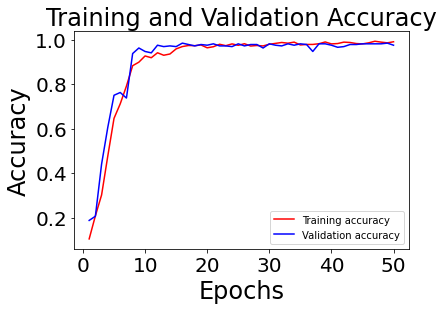

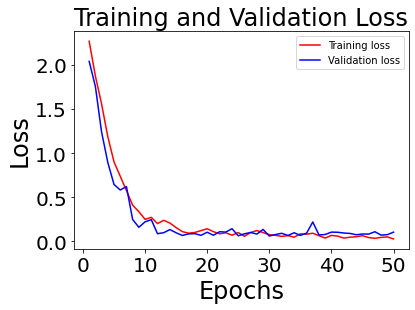

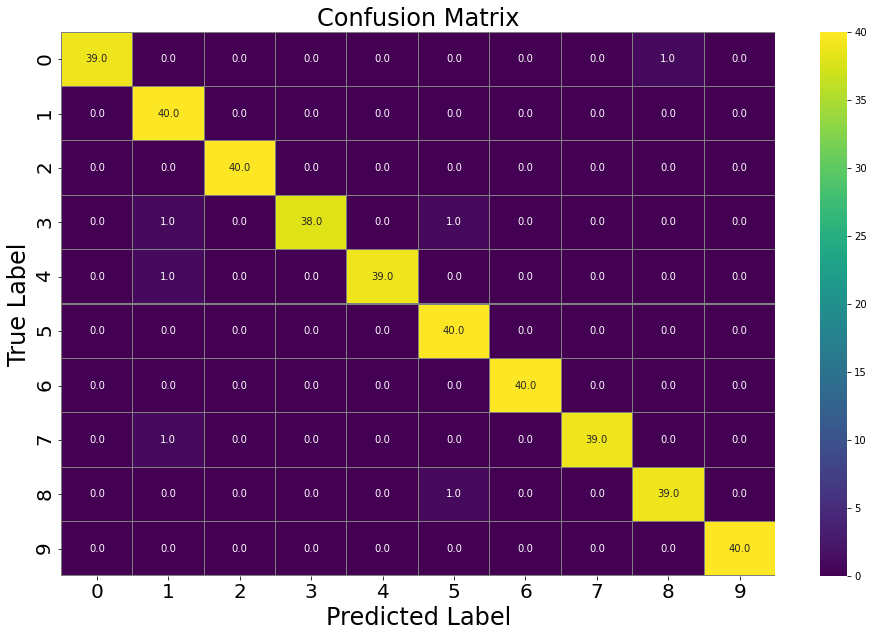

Saved model to disk
[0.04159681329969317, 0.985]


In [60]:
# Train VGG16 on Digits dataset
main("vgg16-train-digits")

Loaded model from disk
[0.06738454896956682, 0.9825]


IndexError: index 7 is out of bounds for axis 0 with size 7

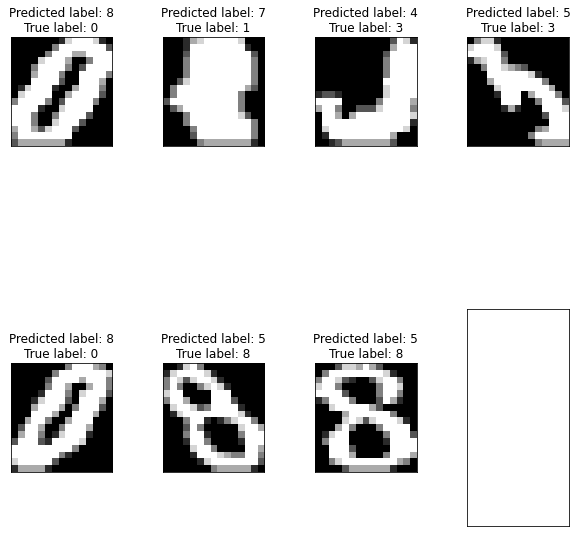

In [39]:
# Test VGG16 on Digits Dataset
main("test-vgg16-digits")

  ...
    to  
  ['...']
Train for 2000 steps, validate on 10000 samples
Epoch 1/50
2000/2000 [==============================] - 68s 34ms/step - loss: 0.3450 - accuracy: 0.8832 - val_loss: 0.0551 - val_accuracy: 0.9858
Epoch 2/50
2000/2000 [==============================] - 65s 32ms/step - loss: 0.0847 - accuracy: 0.9783 - val_loss: 0.1194 - val_accuracy: 0.9772
Epoch 3/50
2000/2000 [==============================] - 67s 33ms/step - loss: 0.0726 - accuracy: 0.9826 - val_loss: 0.0416 - val_accuracy: 0.9914
Epoch 4/50
2000/2000 [==============================] - 65s 32ms/step - loss: 0.0587 - accuracy: 0.9862 - val_loss: 0.0648 - val_accuracy: 0.9874
Epoch 5/50
2000/2000 [==============================] - 67s 33ms/step - loss: 0.0573 - accuracy: 0.9864 - val_loss: 0.0326 - val_accuracy: 0.9922
Epoch 6/50
2000/2000 [==============================] - 67s 33ms/step - loss: 0.0480 - accuracy: 0.9892 - val_loss: 0.0414 - val_accuracy: 0.9929
Epoch 7/50
2000/2000 [=============================

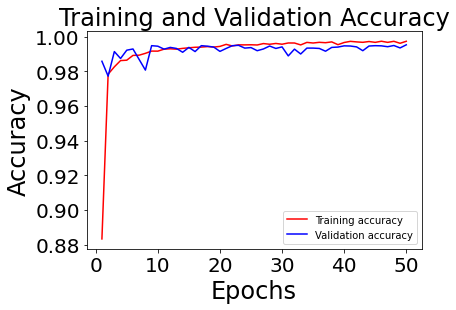

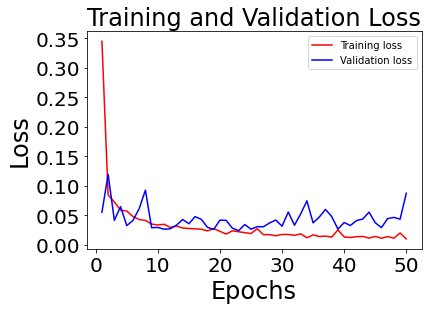

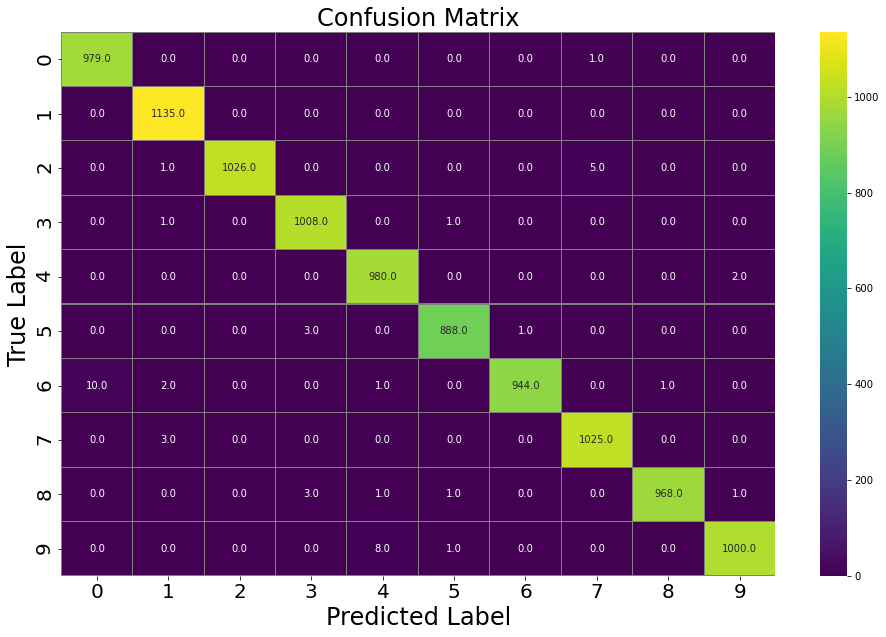

Saved model to disk
[0.04633294346585395, 0.9953]


In [62]:
# Train VGG16 on MNIST dataset
main("vgg16-train-mnist")

Loaded model from disk
[0.04633294346585395, 0.9953]


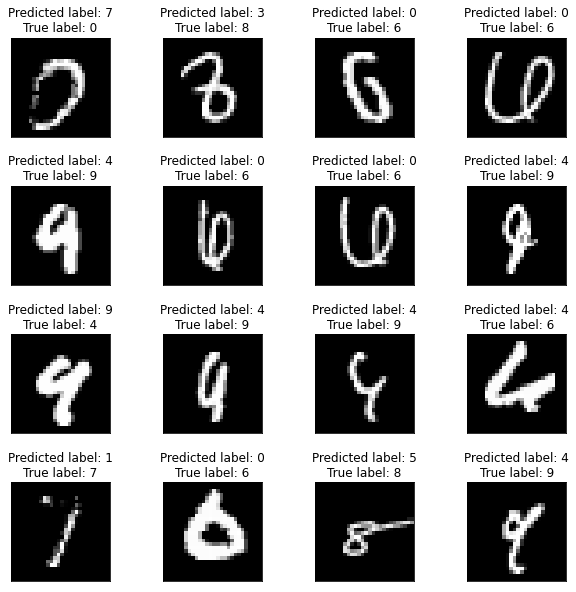

In [27]:
# Test VGG16 on MNIST dataset
main("test-vgg16-mnist")

  ...
    to  
  ['...']
Train for 51 steps, validate on 320 samples
Epoch 1/50
51/51 [==============================] - 5s 99ms/step - loss: 2.3030 - accuracy: 0.0829 - val_loss: 2.3026 - val_accuracy: 0.1000
Epoch 2/50
51/51 [==============================] - 4s 82ms/step - loss: 2.1717 - accuracy: 0.1371 - val_loss: 1.9879 - val_accuracy: 0.1875
Epoch 3/50
51/51 [==============================] - 6s 118ms/step - loss: 1.8990 - accuracy: 0.1960 - val_loss: 1.7639 - val_accuracy: 0.2000
Epoch 4/50
51/51 [==============================] - 5s 101ms/step - loss: 1.6608 - accuracy: 0.2733 - val_loss: 1.5709 - val_accuracy: 0.2875
Epoch 5/50
51/51 [==============================] - 7s 139ms/step - loss: 1.4643 - accuracy: 0.3211 - val_loss: 1.4710 - val_accuracy: 0.3094
Epoch 6/50
51/51 [==============================] - 2s 46ms/step - loss: 1.3679 - accuracy: 0.3633 - val_loss: 1.5766 - val_accuracy: 0.2969
Epoch 7/50
51/51 [==============================] - 4s 84ms/step - loss: 1.3588 - 

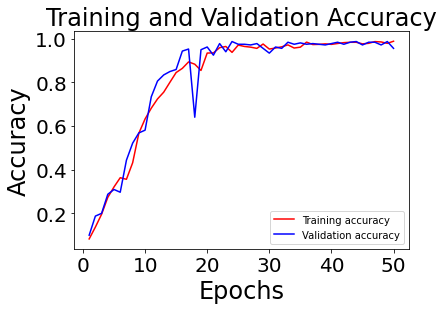

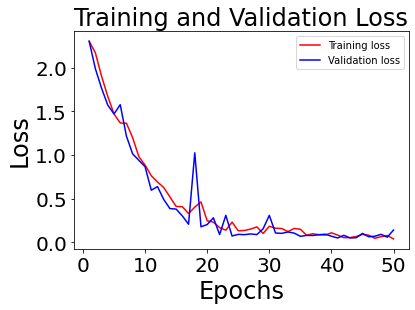

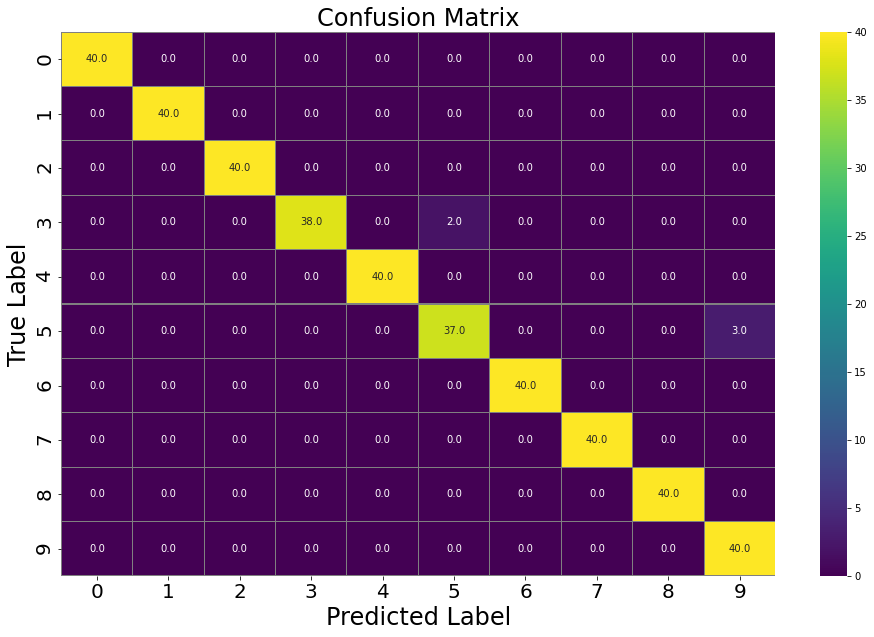

Saved model to disk


In [16]:
# Train VGG19 on Digits dataset
main("vgg19-train-digits")

Loaded model from disk
[0.05515650413930416, 0.9875]


IndexError: index 5 is out of bounds for axis 0 with size 5

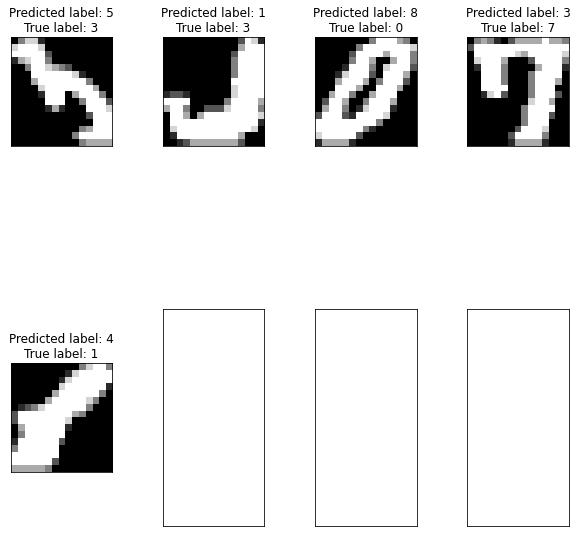

In [40]:
# Test VGG19 on Digits Dataset
main("test-vgg19-digits")

  ...
    to  
  ['...']
Train for 2000 steps, validate on 10000 samples
Epoch 1/50
2000/2000 [==============================] - 83s 42ms/step - loss: 0.4753 - accuracy: 0.8317 - val_loss: 0.0834 - val_accuracy: 0.9797
Epoch 2/50
2000/2000 [==============================] - 84s 42ms/step - loss: 0.1165 - accuracy: 0.9728 - val_loss: 0.0582 - val_accuracy: 0.9872
Epoch 3/50
2000/2000 [==============================] - 85s 42ms/step - loss: 0.0919 - accuracy: 0.9791 - val_loss: 0.0466 - val_accuracy: 0.9909
Epoch 4/50
2000/2000 [==============================] - 82s 41ms/step - loss: 0.0748 - accuracy: 0.9839 - val_loss: 0.0617 - val_accuracy: 0.9869
Epoch 5/50
2000/2000 [==============================] - 80s 40ms/step - loss: 0.0710 - accuracy: 0.9844 - val_loss: 0.0833 - val_accuracy: 0.9840
Epoch 6/50
2000/2000 [==============================] - 81s 40ms/step - loss: 0.0569 - accuracy: 0.9876 - val_loss: 0.0385 - val_accuracy: 0.9928
Epoch 7/50
2000/2000 [=============================

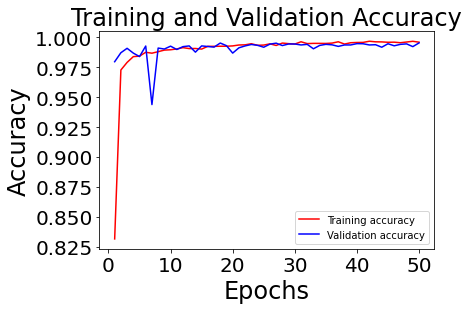

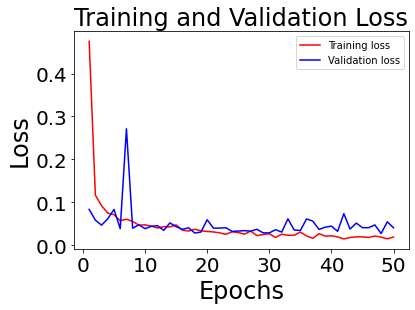

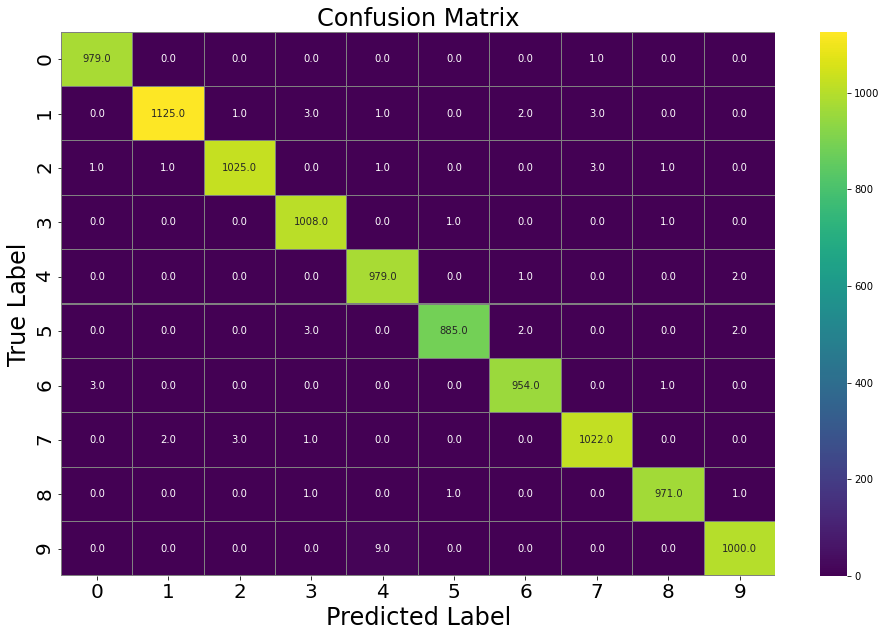

Saved model to disk


In [17]:
# Train VGG19 on MNIST dataset
main("vgg19-train-mnist")

Loaded model from disk
[0.030038597204554623, 0.9948]


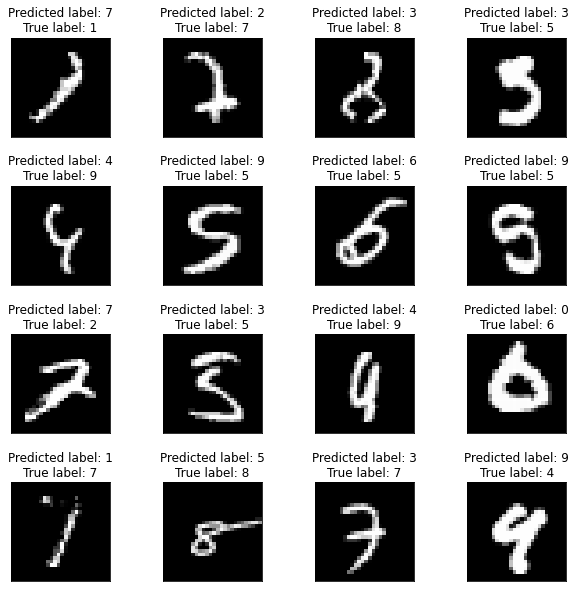

In [22]:
# Test VGG19 on MNIST Dataset
main("test-vgg19-mnist")